## imports

In [1]:
# %pip install pandas numpy torch matplotlib

In [2]:
# %pip install -U scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

## Data preprocessing ##

In [4]:

# # Load the dataset
# df = pd.read_csv('cleaned_data/updated_over_by_over_data_set.csv')

# # Define alpha - weighting parameter (adjust as needed)
# alpha = 0.7  # Higher value gives more weight to current run rate

# # We'll calculate per-over run rate first
# df['curr_run_rate'] = df['total_runs']  # Runs scored in that specific over

# # Initialize column for weighted run rate
# df['weighted_run_rate'] = 0.0

# # Process each match and inning separately
# for (match_id, inning), group in df.groupby(['match_id', 'inning']):
#     # Sort by over to ensure correct sequence
#     group = group.sort_values('over')
    
#     # Initialize weighted run rate with the first over's run rate
#     weighted_rr = group['curr_run_rate'].iloc[0]
    
#     # Process each row and update the weighted run rate
#     for idx, row in group.iterrows():
#         if row['over'] == 1:  # First over - just use its run rate
#             df.at[idx, 'weighted_run_rate'] = row['curr_run_rate']
#         else:
#             # Apply the formula: α(RR_current) + (1-α)(RR_previous_weighted)
#             weighted_rr = alpha * row['curr_run_rate'] + (1-alpha) * weighted_rr
#             df.at[idx, 'weighted_run_rate'] = weighted_rr


# df.drop(columns=['run_rate'])
# # Round for readability
# df['weighted_run_rate'] = df['weighted_run_rate'].round(2)

# # Drop the temporary column
# # df = df.drop(columns=['curr_run_rate'])

# # Sort the dataframe for readability
# df = df.sort_values(['match_id', 'inning', 'over'])

# # Save the updated dataset
# df.to_csv('cleaned_data/weighted_run_rate_dataset.csv', index=False)

# # Display a sample to verify
# print(df[['match_id', 'inning', 'over', 'total_runs', 'weighted_run_rate']].head(20))

# # Optional: Let's also see how the weighted run rate evolves in a few matches
# sample_match = df['match_id'].unique()[0]
# sample_data = df[df['match_id'] == sample_match].sort_values(['inning', 'over'])
# print("\nWeighted Run Rate Evolution for Match", sample_match)
# print(sample_data[['inning', 'over', 'total_runs', 'run_rate', 'curr_run_rate','weighted_run_rate']])




In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")

Using device: cuda
CUDA Device: NVIDIA GeForce MX350
CUDA Memory Allocated: 0.00 MB


## Loading required data and transformations

In [6]:
df = pd.read_csv('cleaned_data/weighted_run_rate_dataset.csv')

df['season'] = df['season'].astype(str)
df['season_year'] = df['season'].apply(lambda x: int(x.split('/')[0]))
max_year = 2024
# df['season_weight'] = np.exp(-0.1 * (max_year - df['season_year']))

# Encode teams using LabelEncoder + Embedding
team_encoder = LabelEncoder()
df['batting_team'] = team_encoder.fit_transform(df['batting_team'])
df['bowling_team'] = team_encoder.fit_transform(df['bowling_team'])


numerical_features = ['over', 'curr_run_rate', 'req_runrate', 'target_left', 'weighted_run_rate']
scaler = StandardScaler()
numerical_data = scaler.fit_transform(df[numerical_features])


match_ids = df['match_id'].unique()
train_match_ids, test_match_ids = train_test_split(match_ids, test_size=0.2, random_state=42)
train_df = df[df['match_id'].isin(train_match_ids)].reset_index(drop=True)
test_df = df[df['match_id'].isin(test_match_ids)].reset_index(drop=True)

# Prepare numerical data for train and test sets
train_numerical_data = scaler.transform(train_df[numerical_features])
test_numerical_data = scaler.transform(test_df[numerical_features])

# Create index mappings for train and test DataFrames
train_index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(train_df.index)}
test_index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(test_df.index)}


## Training Model

In [7]:
class IPLDataset(Dataset):
    def __init__(self, df, numerical_data, index_map):
        self.df = df
        self.numerical_data = numerical_data
        self.index_map = index_map
        self.matches = []

        for match_id in df['match_id'].unique():
            for inning in [1, 2]:
                match_inning = df[(df['match_id'] == match_id) & (df['inning'] == inning)]
                if len(match_inning) > 1:
                    self.matches.append(match_inning.reset_index(drop=True))

    def __len__(self):
        return sum(len(match) - 1 for match in self.matches)

    def __getitem__(self, idx):
        cum_idx = 0
        for match in self.matches:
            match_len = len(match) - 1
            if cum_idx + match_len > idx:
                over_idx = idx - cum_idx
                sequence = match.iloc[:over_idx + 1]
                next_row = match.iloc[over_idx + 1]
                break
            cum_idx += match_len

        team1_seq = torch.tensor(sequence['batting_team'].values, dtype=torch.long)
        team2_seq = torch.tensor(sequence['bowling_team'].values, dtype=torch.long)

        numerical_seq = torch.tensor([
            self.numerical_data[self.index_map[sequence.index[i]]]
            for i in range(len(sequence))
        ], dtype=torch.float32)

        runs = torch.tensor(next_row['total_runs'], dtype=torch.float32)
        wickets = torch.tensor(next_row['is_wicket'], dtype=torch.float32)

        return team1_seq, team2_seq, numerical_seq, runs, wickets


In [8]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    team1_seqs, team2_seqs, num_seqs, runs, wickets = zip(*batch)

    team1_seqs = pad_sequence(team1_seqs, batch_first=True, padding_value=0)
    team2_seqs = pad_sequence(team2_seqs, batch_first=True, padding_value=0)
    num_seqs = pad_sequence(num_seqs, batch_first=True, padding_value=0.0)

    runs = torch.stack(runs)
    wickets = torch.stack(wickets)

    return team1_seqs, team2_seqs, num_seqs, runs, wickets


In [9]:
train_dataset = IPLDataset(train_df, train_numerical_data, train_index_map)
test_dataset = IPLDataset(test_df, test_numerical_data, test_index_map)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)



## Model Architecture

In [10]:
class IPLModelWithTeacherForcing(nn.Module):
    def __init__(self, num_teams, embedding_dim, numerical_dim, hidden_dim):
        super(IPLModelWithTeacherForcing, self).__init__()
        self.team_embedding = nn.Embedding(num_teams, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=2*embedding_dim + numerical_dim + 2,  # +2 for previous runs/wickets
            hidden_size=hidden_dim, 
            batch_first=True
        )
        self.fc_runs = nn.Linear(hidden_dim, 1)
        self.fc_wickets = nn.Linear(hidden_dim, 1)
        
    def forward(self, team1_seq, team2_seq, num_seq, prev_runs=None, prev_wickets=None, teacher_forcing_ratio=0.5):
        batch_size, seq_len = team1_seq.shape
        team1_emb = self.team_embedding(team1_seq)
        team2_emb = self.team_embedding(team2_seq)
        
        # Initialize outputs
        outputs_runs = torch.zeros(batch_size, seq_len, 1).to(team1_seq.device)
        outputs_wickets = torch.zeros(batch_size, seq_len, 1).to(team1_seq.device)
        
        # Initialize previous predictions for first timestep
        if prev_runs is None:
            prev_runs = torch.zeros(batch_size, 1).to(team1_seq.device)
        if prev_wickets is None:
            prev_wickets = torch.zeros(batch_size, 1).to(team1_seq.device)
        
        # Initial hidden state
        h_t = None
        
        # Process sequence step by step
        for t in range(seq_len):
            # Combine team embeddings, numerical features, and previous predictions
            prev_values = torch.cat([prev_runs.unsqueeze(1), prev_wickets.unsqueeze(1)], dim=2)
            x_t = torch.cat([
                team1_emb[:, t:t+1, :], 
                team2_emb[:, t:t+1, :], 
                num_seq[:, t:t+1, :], 
                prev_values
            ], dim=2)
            
            # LSTM step
            lstm_out, h_t = self.lstm(x_t, h_t)
            
            # Predictions
            run_pred = self.fc_runs(lstm_out).squeeze(1)
            wicket_pred = self.fc_wickets(lstm_out).squeeze(1)
            
            # Store predictions
            outputs_runs[:, t] = run_pred
            outputs_wickets[:, t] = wicket_pred
            
            # Teacher forcing: decide whether to use ground truth or prediction
            use_teacher_forcing = (torch.rand(1).item() < teacher_forcing_ratio)
            
            if t < seq_len - 1:  # Not needed for the last timestep
                if use_teacher_forcing and prev_runs is not None:
                    # Use ground truth from training data
                    prev_runs = prev_runs  # Use provided ground truth
                    prev_wickets = prev_wickets
                else:
                    # Use model's own predictions
                    prev_runs = run_pred
                    prev_wickets = wicket_pred
        
        # Return only final timestep predictions for compatibility with current code
        return outputs_runs[:, -1].squeeze(-1), outputs_wickets[:, -1].squeeze(-1)

## Training and Validation Loop

/tmp/ipykernel_82159/4042478309.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  numerical_seq = torch.tensor([


Epoch 1/10 (TF ratio: 1.000):
Train Loss: 25.1196, Test Loss: 22.1207
Train Runs MAE: 3.8639, Test Runs MAE: 3.7658
Train Wickets MAE: 0.4514, Test Wickets MAE: 0.4620
Runs Metrics - Train Acc: 0.1634, Test Acc: 0.1560
Runs Metrics - Train F1: 0.5326, Test F1: 0.5879
Wicket Metrics - Train Acc: 0.7256, Test Acc: 0.7247
Wicket Metrics - Train F1: 0.0042, Test F1: 0.0000
Best model saved with Test Loss: 22.1207
CUDA Memory Allocated: 16.54 MB
Epoch 2/10 (TF ratio: 1.000):
Train Loss: 21.8815, Test Loss: 22.1412
Train Runs MAE: 3.6762, Test Runs MAE: 3.7766
Train Wickets MAE: 0.4531, Test Wickets MAE: 0.4639
Runs Metrics - Train Acc: 0.1641, Test Acc: 0.1539
Runs Metrics - Train F1: 0.5674, Test F1: 0.5902
Wicket Metrics - Train Acc: 0.7256, Test Acc: 0.7247
Wicket Metrics - Train F1: 0.0000, Test F1: 0.0000
CUDA Memory Allocated: 16.54 MB
Epoch 3/10 (TF ratio: 1.000):
Train Loss: 21.6137, Test Loss: 22.4975
Train Runs MAE: 3.6535, Test Runs MAE: 3.8535
Train Wickets MAE: 0.4448, Test Wic

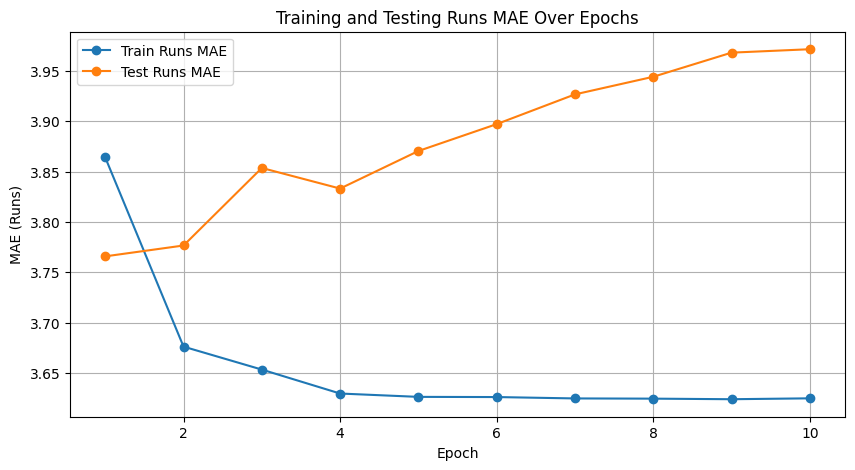

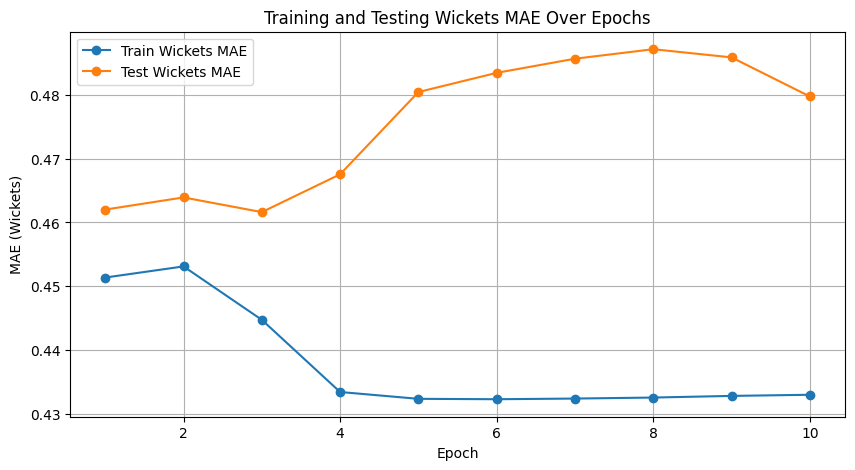

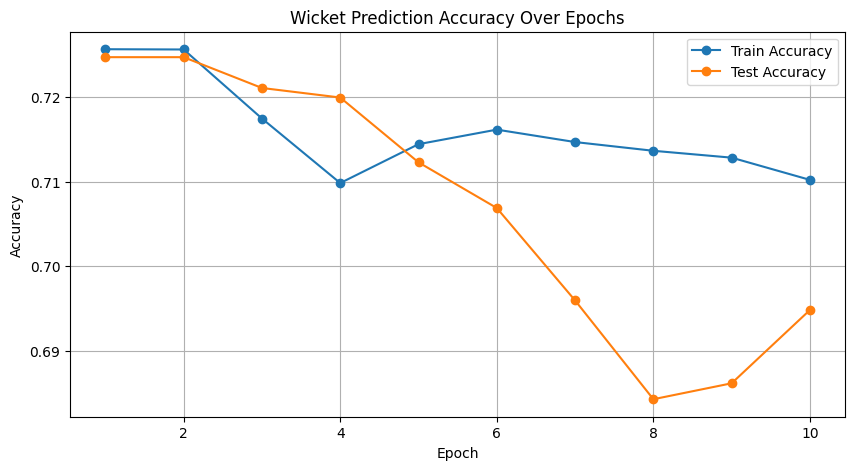

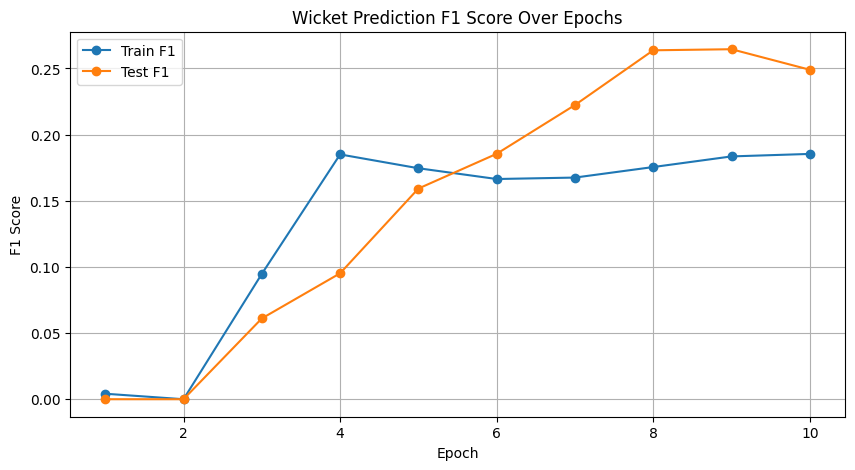

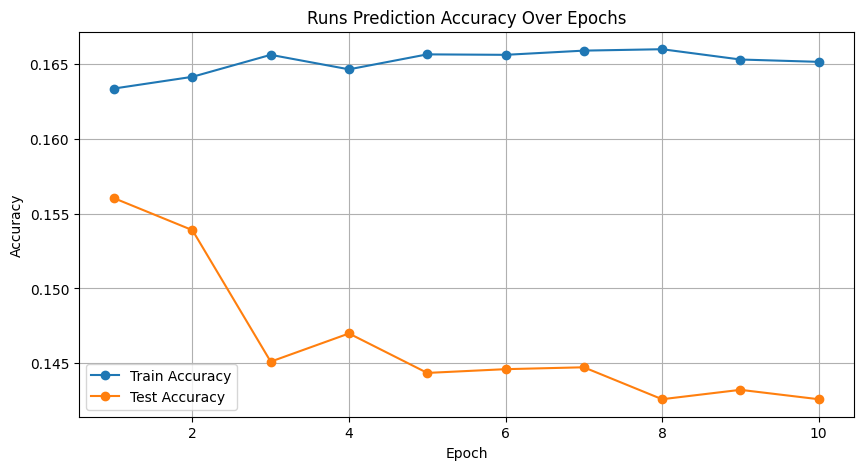

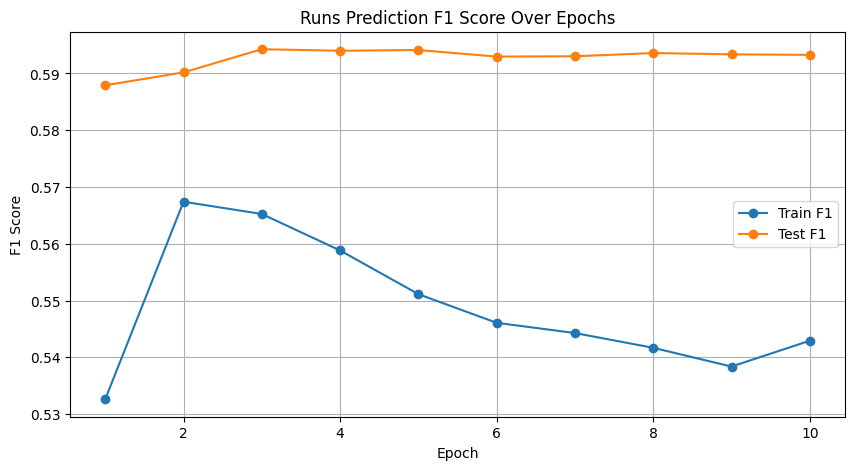

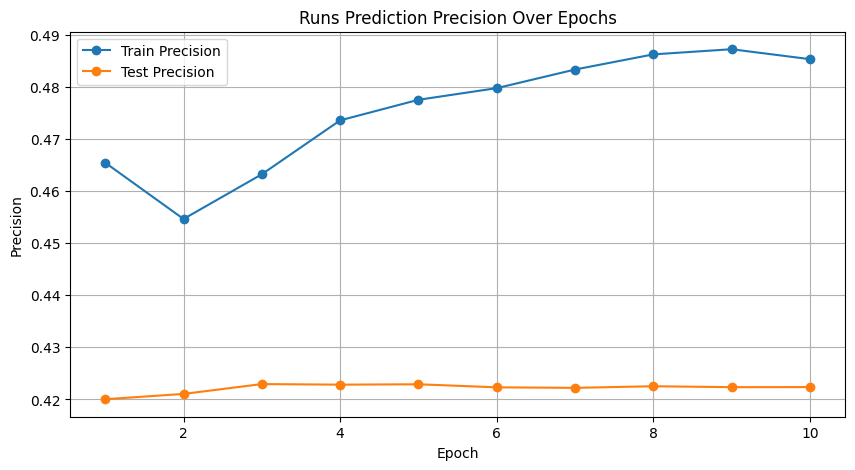

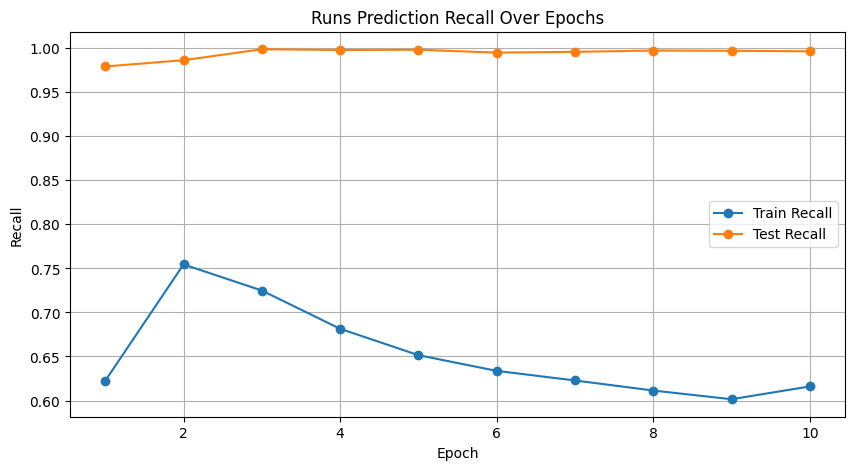

Plots saved as 'loss_over_epochs.png', 'runs_mae_over_epochs.png', 'wickets_mae_over_epochs.png', 'wicket_accuracy_over_epochs.png', and 'wicket_f1_over_epochs.png'


In [11]:
# Create model with teacher forcing
num_teams = len(team_encoder.classes_)
model = IPLModelWithTeacherForcing(
    num_teams=num_teams, 
    embedding_dim=10, 
    numerical_dim=len(numerical_features), 
    hidden_dim=32
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def calculate_runs_metrics(pred_runs, actual_runs, threshold=1.0):
    # Consider a prediction "correct" if it's within threshold runs of actual
    correct_prediction = (torch.abs(pred_runs - actual_runs) <= threshold).float()
    accuracy = correct_prediction.mean().item()
    
    # Define "positive" as cases where actual runs are above the median
    median_runs = torch.median(actual_runs)
    actual_positive = (actual_runs > median_runs).float()
    pred_positive = (pred_runs > median_runs).float()
    
    true_positives = ((pred_positive == 1) & (actual_positive == 1)).sum().float().item()
    false_positives = ((pred_positive == 1) & (actual_positive == 0)).sum().float().item()
    false_negatives = ((pred_positive == 0) & (actual_positive == 1)).sum().float().item()
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return accuracy, precision, recall, f1

# Function to calculate classification metrics for wicket prediction
def calculate_wicket_metrics(pred_wickets, actual_wickets, threshold=0.5):
    # Convert predictions to binary using threshold
    pred_binary = (pred_wickets > threshold).float()
    # Calculate accuracy
    accuracy = (pred_binary == actual_wickets).float().mean().item()
    
    # Calculate TP, FP, FN for precision, recall, F1
    true_positives = ((pred_binary == 1) & (actual_wickets == 1)).sum().float().item()
    false_positives = ((pred_binary == 1) & (actual_wickets == 0)).sum().float().item()
    false_negatives = ((pred_binary == 0) & (actual_wickets == 1)).sum().float().item()
    
    # Calculate precision, recall, F1
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return accuracy, precision, recall, f1
num_epochs = 10
# Lists to store metrics for plotting
train_losses = []
test_losses = []
train_runs_mae = []
test_runs_mae = []
train_wickets_mae = []
test_wickets_mae = []
# Classification metrics
train_wicket_accuracy = []
test_wicket_accuracy = []
train_wicket_precision = []
test_wicket_precision = []
train_wicket_recall = []
test_wicket_recall = []
train_wicket_f1 = []
test_wicket_f1 = []
train_runs_accuracy = []
test_runs_accuracy = []
train_runs_precision = []
test_runs_precision = []
train_runs_recall = []
test_runs_recall = []
train_runs_f1 = []
test_runs_f1 = []
best_test_loss = float("inf")

# Teacher forcing parameters
initial_tf_ratio = 1  # Start with high teacher forcing
final_tf_ratio = 1    # End with low teacher forcing
tf_decay = (final_tf_ratio / initial_tf_ratio) ** (1 / num_epochs)
tf_ratio = initial_tf_ratio

num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_r_mae = 0
    train_w_mae = 0
    all_pred_wickets = []
    all_actual_wickets = []
    all_pred_runs = []
    all_actual_runs = []
    
    for team1_seq, team2_seq, num_seq, runs, wickets in train_loader:
        team1_seq, team2_seq, num_seq = team1_seq.to(device), team2_seq.to(device), num_seq.to(device)
        runs, wickets = runs.to(device), wickets.to(device)

        optimizer.zero_grad()
        
        # Since we don't have direct access to previous runs/wickets in our dataset,
        # we'll create placeholder values
        batch_size = team1_seq.size(0)
        prev_runs = torch.zeros(batch_size, 1).to(device)
        prev_wickets = torch.zeros(batch_size, 1).to(device)
        
        # Forward pass with teacher forcing
        pred_runs, pred_wickets = model(
            team1_seq, team2_seq, num_seq,
            prev_runs=prev_runs,
            prev_wickets=prev_wickets,
            teacher_forcing_ratio=tf_ratio
        )
        
        loss_runs = criterion(pred_runs, runs)
        loss_wickets = criterion(pred_wickets, wickets)
        loss = loss_runs + loss_wickets
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_r_mae += torch.mean(torch.abs(pred_runs - runs)).item()
        train_w_mae += torch.mean(torch.abs(pred_wickets - wickets)).item()
        
        # Store predictions for classification metrics
        all_pred_wickets.append(pred_wickets.detach())
        all_actual_wickets.append(wickets)
        all_pred_runs.append(pred_runs.detach())
        all_actual_runs.append(runs)

    # Decay teacher forcing ratio for next epoch
    tf_ratio *= tf_decay
    
    # Calculate classification metrics for the entire epoch
    all_pred_wickets = torch.cat(all_pred_wickets)
    all_actual_wickets = torch.cat(all_actual_wickets)
    w_acc, w_prec, w_rec, w_f1 = calculate_wicket_metrics(all_pred_wickets, all_actual_wickets)

    all_pred_runs = torch.cat(all_pred_runs)
    all_actual_runs = torch.cat(all_actual_runs)
    r_acc, r_prec, r_rec, r_f1 = calculate_runs_metrics(all_pred_runs, all_actual_runs)
    
    train_losses.append(train_loss / len(train_loader))
    train_runs_mae.append(train_r_mae / len(train_loader))
    train_wickets_mae.append(train_w_mae / len(train_loader))

    train_wicket_accuracy.append(w_acc)
    train_wicket_precision.append(w_prec)
    train_wicket_recall.append(w_rec)
    train_wicket_f1.append(w_f1)

    train_runs_accuracy.append(r_acc)
    train_runs_precision.append(r_prec)
    train_runs_recall.append(r_rec)
    train_runs_f1.append(r_f1)

    # Testing phase - no teacher forcing during evaluation
    model.eval()
    test_loss = 0
    test_r_mae = 0
    test_w_mae = 0
    all_pred_wickets = []
    all_actual_wickets = []
    all_pred_runs = []
    all_actual_runs = []
    
    with torch.no_grad():
        for team1_seq, team2_seq, num_seq, runs, wickets in test_loader:
            team1_seq, team2_seq, num_seq = team1_seq.to(device), team2_seq.to(device), num_seq.to(device)
            runs, wickets = runs.to(device), wickets.to(device)
            
            batch_size = team1_seq.size(0)
            prev_runs = torch.zeros(batch_size, 1).to(device)
            prev_wickets = torch.zeros(batch_size, 1).to(device)
            
            # No teacher forcing during evaluation (tf_ratio=0)
            pred_runs, pred_wickets = model(
                team1_seq, team2_seq, num_seq,
                prev_runs=prev_runs,
                prev_wickets=prev_wickets,
                teacher_forcing_ratio=0.0
            )
            
            loss_runs = criterion(pred_runs, runs)
            loss_wickets = criterion(pred_wickets, wickets)
            loss = loss_runs + loss_wickets
            test_loss += loss.item()
            test_r_mae += torch.mean(torch.abs(pred_runs - runs)).item()
            test_w_mae += torch.mean(torch.abs(pred_wickets - wickets)).item()
            
            # Store predictions for classification metrics
            all_pred_wickets.append(pred_wickets)
            all_actual_wickets.append(wickets)
            all_pred_runs.append(pred_runs)
            all_actual_runs.append(runs)
    
    # Calculate classification metrics for the entire epoch
    all_pred_wickets = torch.cat(all_pred_wickets)
    all_actual_wickets = torch.cat(all_actual_wickets)
    w_acc, w_prec, w_rec, w_f1 = calculate_wicket_metrics(all_pred_wickets, all_actual_wickets)

    all_pred_runs = torch.cat(all_pred_runs)
    all_actual_runs = torch.cat(all_actual_runs)
    r_acc, r_prec, r_rec, r_f1 = calculate_runs_metrics(all_pred_runs, all_actual_runs)
    
    test_losses.append(test_loss / len(test_loader))
    test_runs_mae.append(test_r_mae / len(test_loader))
    test_wickets_mae.append(test_w_mae / len(test_loader))
    
    test_wicket_accuracy.append(w_acc)
    test_wicket_precision.append(w_prec)
    test_wicket_recall.append(w_rec)
    test_wicket_f1.append(w_f1)
    
    test_runs_accuracy.append(r_acc)
    test_runs_precision.append(r_prec)
    test_runs_recall.append(r_rec)
    test_runs_f1.append(r_f1)

    # Print epoch results with additional metrics
    print(f"Epoch {epoch+1}/{num_epochs} (TF ratio: {tf_ratio:.3f}):")
    print(f"Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
    print(f"Train Runs MAE: {train_runs_mae[-1]:.4f}, Test Runs MAE: {test_runs_mae[-1]:.4f}")
    print(f"Train Wickets MAE: {train_wickets_mae[-1]:.4f}, Test Wickets MAE: {test_wickets_mae[-1]:.4f}")
    print(f"Runs Metrics - Train Acc: {train_runs_accuracy[-1]:.4f}, Test Acc: {test_runs_accuracy[-1]:.4f}")
    print(f"Runs Metrics - Train F1: {train_runs_f1[-1]:.4f}, Test F1: {test_runs_f1[-1]:.4f}")
    print(f"Wicket Metrics - Train Acc: {train_wicket_accuracy[-1]:.4f}, Test Acc: {test_wicket_accuracy[-1]:.4f}")
    print(f"Wicket Metrics - Train F1: {train_wicket_f1[-1]:.4f}, Test F1: {test_wicket_f1[-1]:.4f}")

    # Save best model
    if test_losses[-1] < best_test_loss:
        best_test_loss = test_losses[-1]
        torch.save(model.state_dict(), 'best_ipl_model_tf.pth')
        print(f"Best model saved with Test Loss: {best_test_loss:.4f}")
    
    if device.type == 'cuda':
        print(f"CUDA Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")

# Continue with your existing plotting code
epochs = range(1, num_epochs + 1)
# Plot 1: Training vs Testing Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.title('Training and Testing Loss Over Epochs (with Teacher Forcing)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('loss_over_epochs_tf.png')
plt.close()


# Plot 2: Training vs Testing Runs MAE
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_runs_mae, label='Train Runs MAE', marker='o')
plt.plot(epochs, test_runs_mae, label='Test Runs MAE', marker='o')
plt.title('Training and Testing Runs MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE (Runs)')
plt.legend()
plt.grid(True)
plt.savefig('runs_mae_over_epochs.png')
plt.show()
plt.close()

# Plot 3: Training vs Testing Wickets MAE
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_wickets_mae, label='Train Wickets MAE', marker='o')
plt.plot(epochs, test_wickets_mae, label='Test Wickets MAE', marker='o')
plt.title('Training and Testing Wickets MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE (Wickets)')
plt.legend()
plt.grid(True)
plt.savefig('wickets_mae_over_epochs.png')
plt.show()
plt.close()

# Plot 4: Wicket Classification Metrics - Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_wicket_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, test_wicket_accuracy, label='Test Accuracy', marker='o')
plt.title('Wicket Prediction Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('wicket_accuracy_over_epochs.png')
plt.show()
plt.close()

# Plot 5: Wicket Classification Metrics - F1 Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_wicket_f1, label='Train F1', marker='o')
plt.plot(epochs, test_wicket_f1, label='Test F1', marker='o')
plt.title('Wicket Prediction F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('wicket_f1_over_epochs.png')
plt.show()
plt.close()




plt.figure(figsize=(10, 5))
plt.plot(epochs, train_runs_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, test_runs_accuracy, label='Test Accuracy', marker='o')
plt.title('Runs Prediction Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('runs_accuracy_over_epochs.png')
plt.show()
plt.close()

# Plot 7: Runs Classification Metrics - F1 Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_runs_f1, label='Train F1', marker='o')
plt.plot(epochs, test_runs_f1, label='Test F1', marker='o')
plt.title('Runs Prediction F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('runs_f1_over_epochs.png')
plt.show()
plt.close()

# Plot 8: Runs Classification Metrics - Precision 
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_runs_precision, label='Train Precision', marker='o')
plt.plot(epochs, test_runs_precision, label='Test Precision', marker='o')
plt.title('Runs Prediction Precision Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.savefig('runs_precision_over_epochs.png')
plt.show()
plt.close()

# Plot 9: Runs Classification Metrics - Recall
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_runs_recall, label='Train Recall', marker='o')
plt.plot(epochs, test_runs_recall, label='Test Recall', marker='o')
plt.title('Runs Prediction Recall Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.savefig('runs_recall_over_epochs.png')
plt.show()
plt.close()

print("Plots saved as 'loss_over_epochs.png', 'runs_mae_over_epochs.png', 'wickets_mae_over_epochs.png', 'wicket_accuracy_over_epochs.png', and 'wicket_f1_over_epochs.png'")

# Load the best model for inference

In [12]:

# print("\n📥 Loading best model for evaluation...")
# model.load_state_dict(torch.load('best_ipl_model.pth'))
# model.eval()

## Simulating the cricket phase

In [13]:
# def simulate_match(model, team_encoder, scaler, device):
#     model.eval()
#     valid_teams = list(team_encoder.classes_)
#     print("\nAvailable teams:", valid_teams)

#     # 1. Get user input
#     batting_team = input("Batting team: ").strip()
#     bowling_team = input("Bowling team: ").strip()
#     if batting_team not in valid_teams or bowling_team not in valid_teams:
#         print("❌ Invalid team names.")
#         return
    
#     try:
#         innings = int(input("Which innings? (1 or 2): "))
#         current_over = int(input("Current completed over (e.g., 5): "))
#         current_runs = int(input("Current total runs: "))
#         current_wickets = int(input("Current total wickets: "))
#         if innings == 2:
#             target_score = int(input("Target score to win: "))
#         overs_to_simulate = int(input("How many overs do you want to simulate? (e.g., 5): "))
#     except ValueError:
#         print("❌ Invalid input.")
#         return

#     # 2. Initialize state
#     total_runs = current_runs
#     total_wickets = current_wickets

#     team1 = torch.tensor([team_encoder.transform([batting_team])[0]], dtype=torch.long).to(device)
#     team2 = torch.tensor([team_encoder.transform([bowling_team])[0]], dtype=torch.long).to(device)

#     print(f"\n🎯 Simulating from over {current_over + 1} to {current_over + overs_to_simulate}...\n")

#     for i in range(1, overs_to_simulate + 1):
#         over_num = current_over + i
#         if over_num > 20:
#             break  # max 20 overs

#         run_rate = total_runs / over_num if over_num > 0 else 0
#         target_left = (target_score - total_runs) if innings == 2 else 0
#         req_runrate = (target_left / (20 - over_num)) if innings == 2 and (20 - over_num) > 0 else 0
#         season_weight = 1  # default neutral

#         input_data = scaler.transform([[over_num, run_rate, req_runrate, target_left, season_weight]])
#         num_data = torch.tensor(input_data, dtype=torch.float32).to(device)

#         with torch.no_grad():
#             pred_runs, pred_wickets = model(team1, team2, num_data)

#         pred_runs_val = max(0, pred_runs.item())
#         pred_wickets_val = max(0, pred_wickets.item())

#         total_runs += pred_runs_val
#         total_wickets += round(pred_wickets_val)

#         print(f"🟡 Over {over_num}: +{pred_runs_val:.2f} runs, +{pred_wickets_val:.2f} wickets")

#         if total_wickets >= 10:
#             print("🔴 All out!")
#             break

#     print(f"\n🏏 Final Projected Score: {int(total_runs)}/{min(int(total_wickets), 10)}")

#     if innings == 2:
#         if total_runs > target_score:
#             print("✅ Projected WIN by", int(total_runs - target_score), "runs")
#         elif total_runs < target_score:
#             print("❌ Projected LOSS by", int(target_score - total_runs), "runs")
#         else:
#             print("🤝 Projected TIE")


In [14]:
# simulate_match(model, team_encoder, scaler, device)